<a href="https://colab.research.google.com/github/garciasergio94y/TFM/blob/LSTM_onehot_QC/LSTM_RNN_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalación y carga de librerías:

packages <- c("readr", "dplyr", "lubridate", "abind", "tensorflow", 
            "tfdatasets", "keras")

# Función para instalar paquetes si no están ya instalados
install_packages <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    }
}

# Aplicar la función para cada uno de los paquetes
lapply(packages, install_packages)

require(readr)
require(dplyr)
require(lubridate)
require(abind)
require(tensorflow)
require(tfdatasets)
require(keras)


Loading required package: readr

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: abind

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘abind’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: tensorflow

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tensorflow’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppT

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

Loading required package: abind

Loading required package: tensorflow

Loading required package: tfdatasets

Loading required package: keras



In [ ]:
workingdir <- getwd()
datadir <- file.path(workingdir, "Datos/daily_s")
eventdir <- file.path(workingdir, "Datos/daily_s/Event")
eventdir_old <- file.path(workingdir, "Datos/daily_s/Event/old")
lotdir <- file.path(workingdir, "Datos/daily_s/Lot")
lotdir_old <- file.path(workingdir, "Datos/daily_s/Lot/old")
qcdir <- file.path(workingdir, "Datos/daily_s/qc")
qcdir_old <- file.path(workingdir, "Datos/daily_s/qc/old")
resultsdir <- file.path(workingdir, "Resultados")

In [ ]:
tensorflow::tf_gpu_configured()

TensorFlow built with CUDA:  TRUE 
GPU device name:  /device:GPU:0

[1] TRUE

Lectura de archivos de datos

In [ ]:
# Leer archivo dataset desde Github:
url <- "https://raw.githubusercontent.com/garciasergio94y/TFM/LSTM_onehot_QC/Resultados/qc_data_sel_code?token=GHSAT0AAAAAACCRT74VJ2YKEZOTW42SNHUOZDJCPOA"
dataset <- read.csv(url)

# Guardar una copia local:
write.csv(dataset, file = "dataset", row.names = F, col.names = F) 


Warning message in write.csv(dataset, file = "dataset", row.names = F, col.names = F):
“attempt to set 'col.names' ignored”


In [ ]:
# Convertir fechas en formato POSIXct:
dataset[,1] %<>% as.POSIXct(tz = "Europe/Madrid")
head(dataset)

,TIEMPO_QC,QC_RESULT,W1,W2,W3,W4,W5,W6,W7,W8,⋯,CODIGO_PRUEBA_CLC11775,CODIGO_PRUEBA_CLC11797,CODIGO_PRUEBA_CLC11816,CODIGO_PRUEBA_CLC11837,CODIGO_PRUEBA_CLC11846,CODIGO_PRUEBA_CLC11854,CODIGO_PRUEBA_CLC11977,NIVEL_1,NIVEL_2,NIVEL_3
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2023-02-27 09:17:02,401.4,-0.8187106,2.346507,0.9610441,-0.3107763,-0.1775268,0.3255184,0.8167310,-6.142909,⋯,0,0,0,0,0,0,0,0,0,1
2,2023-02-27 09:14:55,141.3,-4.5261548,4.956461,-1.2164387,0.3156106,-0.3187019,0.3403828,0.8025504,-6.197191,⋯,0,0,0,0,0,0,0,0,1,0
3,2023-02-27 09:13:25,52.0,13.6292573,-2.518665,-2.4838886,0.9983201,-0.4562898,0.3537129,0.7871937,-6.249534,⋯,0,0,0,0,0,0,0,1,0,0
4,2023-02-24 09:18:42,421.7,-7.7481720,-4.007593,-2.0528090,1.6754877,-0.5853349,0.3652882,0.7706627,-6.299906,⋯,0,0,0,0,0,0,0,0,0,1
5,2023-02-24 09:16:27,51.0,-1.8348034,1.044108,-0.8652081,2.2508911,-0.7013276,0.3746887,0.7529580,-6.348276,⋯,0,0,0,0,0,0,0,1,0,0
6,2023-02-24 09:15:51,140.7,-2.1822976,4.332115,0.3628108,2.6589775,-0.8010154,0.3815874,0.7340782,-6.394616,⋯,0,0,0,0,0,0,0,0,1,0


Definición de funciones para transformación de variables, normalización y secuenciación de series de datos:

In [ ]:
# Función de normalización de las variables continuas y eliminación de coeficientes wavelet con valores NA. Se definen dos funciones, una para el set de training y otra para los sets de test y validación. La diferencia es que la de train devuelve vectores de medias y de desviaciones estándar que luego se usan como argumentos en las otras. De esta forma, el escalado y normalización se realiza con la misma media y desviación del set de entrenamiento para los otros dos datasets:

normalize_train <- function(data) {
   
  # Identificar las columnas que empiezan por W y la columna 'RESULTADO'
  wavelet_cols <- grep("^[WV]", colnames(data), value = TRUE)
  result_col <- "RESULTADO"
  
  if (!"CODIGO_PRUEBA" %in% names(data)) {
    # Calcular medias y desviaciones estandar para cada variable:
    means <- data %>%
    summarise(across(c(result_col, wavelet_cols),
                     ~mean(., na.rm = T)))
  
    std_devs <- data %>% 
    summarise(across(c(result_col, wavelet_cols),
                     ~sd(., na.rm = T)))
    
    # Normalizar las columnas de resultados, coeficientes y
    # escalas wavelet y hacer padding con 9999 en valores NA:
    norm_data <- data %>%
      mutate(across(c(result_col, wavelet_cols), scale)) %>%
      mutate(across(wavelet_cols,
                           ~ifelse(is.na(.), -99999, .)))
  
  } else {
    
    # Calcular medias y desviaciones estándar:
    means <- data %>%
      group_by(CODIGO_PRUEBA)
      summarise(across(c(result_col, wavelet_cols),
                     ~mean(., na.rm = T)))
  
  std_devs <- data %>% 
    group_by(CODIGO_PRUEBA) %>% 
    summarise(across(c(result_col, wavelet_cols),
                     ~sd(., na.rm = T)))
  
  # Normalizar las columnas de resultado y coeficientes wavelet
  norm_data <- data %>% 
  group_by(CODIGO_PRUEBA) %>% 
  mutate(across(c(result_col, wavelet_cols), scale))%>%
    mutate(across(wavelet_cols,
                           ~ifelse(is.na(.), -99999, .))) %>%
    ungroup()
  
  # Eliminar columna CODIGO_PRUEBA:
  norm_data <- norm_data[,-which(names(norm_data)==
                                   "CODIGO_PRUEBA")]
  }
  
  # Devolver el dataframe escalado y las medias y desviaciones estándar:
  
  return(list(scaled_data = as.data.frame(norm_data), 
              means = means, stdev = std_devs))
}


In [ ]:
# Función de normalización para los datos de validación y test, con eliminación de valores NA en los wavelets:

norm_onehot_test_val <- function(data, means, stds) {
  
  if (!"CODIGO_PRUEBA" %in% names(data)) {
    
  # Identificar las columnas numéricas y seleccionarlas
  wavelet_cols <- grep("^[WV]", colnames(data), value = TRUE)
  result_col <- c("RESULTADO")
  
  # Seleccionar medias y desviaciones de resultados y coeficientes   wavelet:
  means_r <- unlist(means[result_col])
  stds_r <- unlist(stds[result_col])
  means_wl <- unlist(means[wavelet_cols])
  stds_wl <- unlist(stds[wavelet_cols])
  
  # Normalizar las columnas de resultado y coeficientes wavelet usando las medias y desviaciones estándar de train suministradas:
  
  norm_data <- data %>% 
  mutate(result_col = (.[result_col] - means_r) / stds_r,
         wavelet_cols = (.[wavelet_cols] - means_wl)/ stds_wl,
         .keep = "unused") %>%
    select(-c(grep("^[WV]", colnames(data), value = TRUE), "RESULTADO")) %>%
    unnest(cols = c(result_col, wavelet_cols)) %>%
    relocate(RESULTADO, .after = 1) %>%
    relocate(starts_with("V"), .after = 2) %>%
    relocate(starts_with("W"), .after = 2) %>%
    # Padding con 9999 en filas con valores NA:
    mutate(across(wavelet_cols,
                           ~ifelse(is.na(.), -99999, .)))
  
  } else {
  
  # Identificar las columnas numéricas y seleccionarlas
  wavelet_cols <- grep("^[WV]", colnames(data), value = TRUE)
  result_col <- "RESULTADO"
  test_cols <- "CODIGO_PRUEBA"
  cols <- c(result_col, wavelet_cols, test_cols)
  
  # Normalizar por cada prueba las columnas de resultado y coeficientes wavelet
  # usando las medias y desviaciones estándar de train suministradas:
  
  norm_data <- data %>% 
    merge(., 
          merge(means[, cols], stds[,cols], by = "CODIGO_PRUEBA"),
          by = "CODIGO_PRUEBA") %>%
    group_by(CODIGO_PRUEBA) %>%
    mutate(across(c(result_col, wavelet_cols),
                  ~ (. - get(paste0(cur_column(), ".x"))) /
                    get(paste0(cur_column(), ".y"))),
           .keep = "unused") %>%
    # Padding con -99999 en filas con valores NA:
    mutate(across(wavelet_cols,
                           ~ifelse(is.na(.), -99999, .))) %>%
    ungroup()
  
  norm_data <- norm_data[,-which(names(norm_data)==
                                   "CODIGO_PRUEBA")]
  }
  
  return(as.data.frame(norm_data))
}



In [ ]:
# Función para crear un índice de casos únicos de combinaciones de ANALIZADOR, CÓDIGO_PRUEBA y NIVEL:

unique_lab_cases <- function(df, categorical_vars) {
  unique_groups <- unique(df[categorical_vars])
  
  index <- apply(unique_groups, 1, function(row) {
    paste0(ifelse(row == 1, 1, 0), collapse = "")
  })
  unique_groups %<>% mutate(., index)
  indexed_df <- df %>%
    merge(unique_groups, ., by = colnames(unique_groups)
          [-length(colnames(unique_groups))])
  indexed_df <- indexed_df[, c(colnames(df), "index")]
  
  return(indexed_df)
}


In [ ]:
# Función para creación de lotes de series temporales de longitud k (lookback)

create_lstm_data.2 <- 
  function(data, lookback, delay, min_index, max_index,
           shuffle = FALSE, batch_size, step = 1,
           predseries) {
  
  if (is.null(max_index)) max_index <- nrow(data) - delay - 1
  i <- min_index + lookback
  function() {
    if (shuffle) {
      rows <- sample(c((min_index+lookback):max_index), 
                     size = batch_size)
    } else {
      if (i + batch_size >= max_index)
        i <<- min_index + lookback
      rows <- c(i:min(i+batch_size, max_index))
      i <<- i + length(rows)
}
    samples <- array(0, dim = c(length(rows),
                                lookback / step,
                                dim(data)[[-1]]))
    targets <- array(0, dim = c(length(rows)))
    for (j in 1:length(rows)) {
      indices <- seq(rows[[j]] - lookback, rows[[j]],
                     length.out = dim(samples)[[2]])
      samples[j,,] <- data[indices, ]
      targets[[j]] <- data[rows[[j]] + delay,predseries]
    }
    list(samples, targets)
  }
}


In [ ]:
# Se divide el dataset en 50% de datos para entrenamiento, 25% para test y 25% para validación.
# Para evitar fraccionar las unidades temporales diarias usamos percentiles de la secuencia temporal en días: 

time_point_50 <- as.POSIXct(as.Date(
  quantile(dataset[,1], 0.5)))

time_point_75 <- as.POSIXct(as.Date(
  quantile(dataset[,1], 0.75)))

time_point_50
time_point_75

             50% 
"2022-09-02 UTC" 

             75% 
"2022-12-02 UTC" 

In [ ]:
# Muestra de entrenamiento:
train <- dataset %>%
  subset(dataset[,1] <= time_point_75) %>%
  # Normalización del dataset y eliminación de coeficientes
  # wavelet con valor NA:
  normalize_train()

Warning message:
“There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `across(c(result_col, wavelet_cols), ~mean(., na.rm = T))`.
Caused by warning:
! Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(result_col)

  # Now:
  data %>% select(all_of(result_col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [ ]:
# Muestra de validación:
val <- dataset %>%
  subset(
    #data_sel_code$data[,1] > time_point_50 &
    dataset[,1] > time_point_75) %>%
  # Normalización del dataset y eliminación de coeficientes
  # wavelet con valor NA:
  norm_onehot_test_val(means = train$means, stds = train$stdev)

In [ ]:
# Creación de series temporales de tamaño k con los datos de training:
# Índices identificativos de analizador, código de reactivo y nivel:
train_indx <- unique_lab_cases(train$scaled_data, categorical_vars = c(15:46))[,-1]

# Extraemos lo índices para realizar un diccionario de traducción de índices a códigos únicos numéricos:
index_values <- unique(train_indx[,"index"])
index_dictionary <- data.frame(index = index_values)
index_dictionary$code <- as.numeric(factor(index_values, levels = index_values))

# Sustituimos los índices de train_indx por sus códigos:
train_indx$index <- index_dictionary$code[match(train_indx$index, index_dictionary$index)]
index_values <- unique(train_indx[,"index"])

# Hiperparámetros para generar las series temporales:
lookback <- 20 # Longitud de la secuencia previa al target.
delay <- 1 # Escoge como target el valor k+1 en el futuro.
batch_size <- 200 # Tamaño de batch.
min_index <- 1 # Indice de partida de la serie temporal.
predseries <- 1 # Posición en el dataset de la variable a predecir (QC_RESULT)

# Creación de las series temporales de longitud k por categorías de combinaciones únicas de analizador, código de prueba y nivel de QC:
 
train_k <- lapply(index_values, function(idx) {
  create_lstm_data.2(
    data = as.matrix(train_indx[train_indx[,"index"] == idx,
                                - length(train_indx)]),
    lookback = lookback,
    delay = delay,
    batch_size = batch_size,
    min_index = min_index,
    max_index = 
      nrow(as.matrix(train_indx[train_indx[,"index"] == idx,])),
    predseries = predseries)
})

# Cálculo del número de steps de training:
train_steps <- round((nrow(train$scaled_data) - lookback) / batch_size)

In [ ]:
val_indx <- unique_lab_cases(val, categorical_vars = c(15:46))[,-1]

# Usamos el diccionario de códigos creado anteriormente: 
val_indx$index <- index_dictionary$code[match(val_indx$index, index_dictionary$index)]
index_values <- unique(val_indx[,"index"]) 

val_k <- lapply(index_values, function(idx) {
  create_lstm_data.2(
    data = as.matrix(val_indx[val_indx[,"index"] == idx,
                              - length(val_indx)]),
    lookback = lookback,
    delay = delay,
    batch_size = batch_size,
    min_index = min_index,
    max_index = 
      nrow(as.matrix(val_indx[val_indx[,"index"] == idx,])),
    predseries = predseries)
})

# Cálculo del número de steps de validación:
val_steps <- val_steps <- ceiling(nrow(val) / batch_size)

In [ ]:
# Funciones generadoras de series para train y validation, Estas funciones generan 
# de manera indefinida series con los datos de entrenamiento y validación, usando 
# de manera consecutiva las funciones generadoras almacenadas junto a los subconjuntos 
# de datos con las 160 posibles combinaciones de ANALIZADOR, CÓDIGO_PRUEBA y NIVEL de QC
# sobre los que cada una tiene que actuar. Si se llega a la generación número 160 
# se repite el proceso desde la primera.  

index_train <- 1

train_gen <- function() {
  if (index_train > length(train_k)) {
      index_train <<- 1
  }
    
  sequence <- train_k[[index_train]]()
  index_train <<- index_train + 1
  
  return(sequence)
}

index_val <- 1

val_gen <- function() {
  if (index_val > length(val_k)) {
    index_val <<- 1
  }

  sequence <- val_k[[index_val]]()
  index_val <<- index_val + 1
  
  return(sequence)
}

In [ ]:
# Función para calcular el MAE promedio para un modelo basado en predecir los targets 
# del set de validación con las mismas muestras de validación, mediante la iteración 
# de lotes de muestras. Esto sería equivalente a un modelo que predice el resultado 
# futuro del QC con el actual y constituye el punto de partida para mejorar (common sense baseline).

evaluate_naive_method <- function() {
  batch_maes <- c()
  for (step in 1:val_steps) {
    c(samples, targets) %<-% val_gen()
    preds <- samples[,dim(samples)[[2]],2]
    mae <- mean(abs(preds - targets))
    batch_maes <- c(batch_maes, mae)
  }
  print(mean(batch_maes))
}

maes <- evaluate_naive_method()
cbind(train$stdev[[1]], maes*train$stdev[[2]])

[1] 3.975875


CLC00033,53.5918894310736
CLC00034,5.57748042439256
CLC00061,183.733326859503
CLC00415,381.81579837991
CLC00544,88.998850198785
CLC00638,28.4827195332944
CLC00805,681.912102074728
CLC00807,222.808695650046
CLC00811,17.7739267983337
CLC00813,319.102338561277
CLC00814,66.3543590252383


In [ ]:
set.seed(123)

model_2 <- keras_model_sequential() %>%
    layer_lstm(units = 32, dropout=0.1, recurrent_dropout=0.5,
              #return_sequences = TRUE,
              input_shape = list(NULL, dim(train$scaled_data[,-1])[[-1]])) %>%
    #layer_lstm(units = 64, activation="relu", 
               #dropout=0.1, recurrent_dropout=0.5) %>%
    layer_dense(units = 1)

In [ ]:
rmse <- function(y_pred, y_true) {
  backend <- keras::backend()
  sq_diff <- backend$square(y_pred - y_true)
  mean_sq_diff <- backend$mean(sq_diff, axis = -1)
  rmse_value <- backend$sqrt(mean_sq_diff)
  rmse_value <- backend$cast(rmse_value, dtype = "float32")
  rmse_value
}


In [ ]:
model_2 %>% compile(
    optimizer = "rmsprop",
    loss="mse", 
    metrics = list("mse", "mae")
)

callbacks <- list(
  callback_model_checkpoint(file.path(resultsdir, "lstm_2.keras",
                                     save_best_only = TRUE)))

In [ ]:
# Entrenar el modelo:
history_2 <- model_2 %>% fit_generator(
  generator = train_gen,
  steps_per_epoch = train_steps,
  epochs = 20,
  validation_data = val_gen,
  validation_steps = val_steps,
  callbacks = callbacks
)

Warning message in fit_generator(., generator = train_gen, steps_per_epoch = train_steps, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


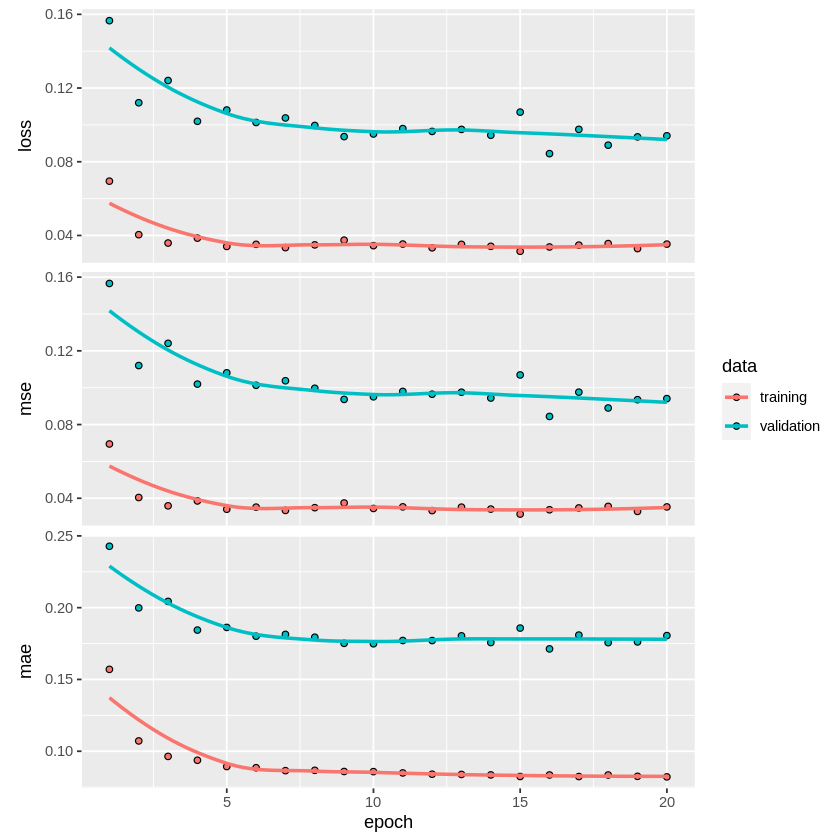

In [ ]:
plot(history_2)